In [202]:
import pandas as pd
import os
from scipy.stats import ttest_ind
import seaborn as sns

sns.despine()
sns.set_style("white")
sns.set_context("paper")

<Figure size 432x288 with 0 Axes>

In [227]:
phenotypes = ['Acute and unspecified renal failure',
 'Acute cerebrovascular disease',
 'Acute myocardial infarction',
 'Cardiac dysrhythmias',
 'Chronic kidney disease',
 'Chronic obstructive pulmonary disease and bronchiectasis',
 'Complications of surgical procedures or medical care',
 'Conduction disorders',
 'Congestive heart failure; nonhypertensive',
 'Coronary atherosclerosis and other heart disease',
 'Diabetes mellitus with complications',
 'Diabetes mellitus without complication',
 'Disorders of lipid metabolism',
 'Essential hypertension',
 'Fluid and electrolyte disorders',
 'Gastrointestinal hemorrhage',
 'Hypertension with complications and secondary hypertension',
 'Other liver diseases',
 'Other lower respiratory disease',
 'Other upper respiratory disease',
 'Pleurisy; pneumothorax; pulmonary collapse',
 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
 'Respiratory failure; insufficiency; arrest (adult)',
 'Septicemia (except in labor)',
 'Shock',
 'any_chronic',
 'any_acute',
 'any_disease']

In [204]:
base_path = "/om/user/shobhita/data/6.864/"
pf_race_nodro_path = base_path + "task_phenotype_first_outputs_dro_False_group_ethnicity_to_use_freezebert_True/"
pf_race_dro_path = base_path + "task_phenotype_first_outputs_dro_True_group_ethnicity_to_use_freezebert_True/"
pf_gender_nodro_path = base_path + "task_phenotype_first_outputs_dro_False_group_gender_freezebert_True/"
pf_gender_dro_path = base_path + "task_phenotype_first_outputs_dro_True_group_gender_freezebert_True/"

In [412]:
output_dir = "/om/user/shobhita/src/HurtfulWords/analysis/"

# Functions

In [128]:
def to_dict(results, reverse=False):
    results_df_dict = []
    for col, col_results in results.items():
        col_results["Task"] = col
        col_results["Improved?"] = abs(col_results["DRO"]) < abs(col_results["ERM"]) if not reverse else abs(col_results["ERM"]) < abs(col_results["DRO"]) 
        results_df_dict.append(col_results)
    results = pd.DataFrame(results_df_dict)
    return results

def get_gender_results(opt="all", as_df=False):
    results = {}

    for using_dro, path in zip(["DRO", "ERM"], [pf_gender_dro_path, pf_gender_nodro_path]):
        for col in os.listdir(path):
            full_path = path + col + "/group_metrics.pkl"
            result = pd.read_pickle(full_path)
            name = col.split("_")[-1]
            if opt=="change":
                accuracy_result = result['group metrics'][0]['acc'] - result['group metrics'][1]['acc']
            else:
                accuracy_result = {k: v['acc'] for k, v in result['group metrics'].items()}
            if name in results:
                    results[name][using_dro] = accuracy_result
            else:
                results[name] = {}
                results[name][using_dro] = accuracy_result
    if as_df:
        results = to_dict(results)
    return results

In [55]:
from statistics import mean, stdev

races = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Hispanic",
    4: "Other",
    5: "Unknown"
}

def get_race_results(option="all", as_df=False):
    results = {}

    for using_dro, path in zip(["DRO", "ERM"], [pf_race_dro_path, pf_race_nodro_path]):
        for col in os.listdir(path):
            full_path = path + col + "/group_metrics.pkl"
            result = pd.read_pickle(full_path)
            name = col.split("_")[-1]
            if option == "white_v_nonwhite":
                accuracy_result = result['group metrics'][0]['acc'] - mean([result['group metrics'][x]['acc'] for x in range(1, 4)])
            elif option == "white_v_black":
                accuracy_result = result['group metrics'][0]['acc'] - result['group metrics'][1]['acc']
            elif option == "white_v_asian":
                accuracy_result = result['group metrics'][0]['acc'] - result['group metrics'][2]['acc']
            elif option == "white_v_hispanic":
                accuracy_result = result['group metrics'][0]['acc'] - result['group metrics'][3]['acc']
            else:
                accuracy_result = {k: v['acc'] for k, v in result['group metrics'].items()}
            
            if name in results:
                results[name][using_dro] = accuracy_result
            else:
                results[name] = {}
                results[name][using_dro] = accuracy_result
    if as_df: 
        if option in ["white_v_nonwhite", "white_v_black", "white_v_asian", "white_v_hispanic"]:
            return to_dict(results)
            
        elif option == "worst_group":
            results = {col: {
                "DRO": min(list(col_res["DRO"].values())), 
                "ERM": min(list(col_res["ERM"].values()))} 
                       for col, col_res in results.items()}
            return to_dict(results)
    return results

In [132]:
def get_basic_metrics(df):
    metrics = {}
    metrics["percent_improved"] = len(df[df["Improved?"] == True])/len(df)
    metrics["mean_bias"] = df["NO DRO"].abs().mean()
    metrics["std_bias"] = df["NO DRO"].abs().std()
    return metrics

def get_basic_results(results):
    results_table = []
    for disease, dres in results.items():
        metrics = {}
        metrics["Acc_DRO"] = mean(list(dres["DRO"].values()))
        metrics["Acc_ERM"] = mean(list(dres["ERM"].values()))
        metrics["WG_Acc_DRO"] = min(list(dres["DRO"].values()))
        metrics["WG_Acc_ERM"] = min(list(dres["ERM"].values()))
        metrics["WG_Acc_Improved?"] = metrics["WG_Acc_DRO"] > metrics["WG_Acc_ERM"]
        metrics["WG_DRO"] = [races[k] for k, v in dres["DRO"].items() if v == min(list(dres["DRO"].values()))][0]
        metrics["WG_ERM"] = [races[k] for k, v in dres["ERM"].items() if v == min(list(dres["ERM"].values()))][0]
        metrics["Disease"] = disease

        results_table.append(metrics)
    results_table = pd.DataFrame(results_table)

    summary = pd.DataFrame({"Acc_decrease": results_table["Acc_ERM"] - results_table["Acc_DRO"].mean(), 
                           "WG_Acc_improvement": results_table["WG_Acc_DRO"] - results_table["WG_Acc_ERM"],
                           "WG_Changed?": results_table["WG_DRO"] != results_table["WG_ERM"]})
    return results_table, summary

In [ ]:
def get_losses(outputs_path):
    for col in os.listdir(path):
        full_path = path + col + "/losses.pkl"
        disease = col.split("_")[-1]
        new_path = output_path + f"{name}_{disease}.pkl"
        result = pd.read_pickle(full_path)
        with open(new_path, "wb") as handle:
            pickle.dump(result, handle)
        print(f"Done with {name}, {col}")

In [226]:
def get_loss_df(dro_path, nodro_path, phenotype):
    loss_nodro = pd.read_pickle(nodro_path + f"phenotype_first_baseline_clinical_BERT_1_epoch_512_{phenotype}/" + "losses.pkl")
    loss_dro = pd.read_pickle(dro_path + f"phenotype_first_baseline_clinical_BERT_1_epoch_512_{phenotype}/" + "losses.pkl")
    for i, res in enumerate(loss_dro):
        loss_dro[i]['DRO'] = True
        loss_dro[i]['Epoch'] = i+1

    for i, res in enumerate(loss_nodro):
        loss_nodro[i]['DRO'] = False
        loss_nodro[i]['Epoch'] = i+1

    return pd.concat([pd.DataFrame(loss_dro), pd.DataFrame(loss_nodro)])

# GENDER RESULTS

## Building results table

In [283]:
gender_results = get_gender_results(opt="all")

results_table, summary = get_basic_results(gender_results)

In [285]:
results_table.head()

,Acc_DRO,Acc_ERM,WG_Acc_DRO,WG_Acc_ERM,WG_Acc_Improved?,WG_DRO,WG_ERM,Disease
0,0.735504,0.726306,0.714810,0.715422,False,White,White,Cardiac dysrhythmias
1,0.798683,0.797857,0.795041,0.793388,True,Black,Black,Diabetes mellitus without complication
2,0.937415,0.940598,0.932681,0.935741,False,White,White,Other liver diseases
3,0.831843,0.831430,0.828926,0.828099,True,Black,Black,Complications of surgical procedures or medica...
4,0.628262,0.631202,0.620661,0.628519,False,Black,White,Essential hypertension


In [286]:
results_table.to_csv(output_dir + "gender_PF_summary.csv", index=False)

## Summary stats

In [287]:
print("Avg avg accuracy decrease: ", (results_table["Acc_ERM"] - results_table["Acc_DRO"]).mean())
print("Percent of Diseases with Avg acc increase: ", (results_table["Acc_ERM"] < results_table["Acc_DRO"]).mean())
print("Percent of Diseases with Avg acc decrease: ", (results_table["Acc_ERM"] > results_table["Acc_DRO"]).mean())
print("Percent of Diseases with WG Acc increase: ", (results_table["WG_Acc_DRO"] > results_table["WG_Acc_ERM"]).mean())
print("Avg ERM WG Acc when DRO works:", (results_table["WG_Acc_ERM"][results_table["WG_Acc_Improved?"] == True]).mean())
print("Avg ERM WG Acc when DRO doesn't work:", (results_table["WG_Acc_ERM"][results_table["WG_Acc_Improved?"] == False]).mean()) 

Avg avg accuracy decrease:  -0.0006159149073914865
Percent of Diseases with Avg acc increase:  0.5714285714285714
Percent of Diseases with Avg acc decrease:  0.39285714285714285
Percent of Diseases with WG Acc increase:  0.42857142857142855
Avg ERM WG Acc when DRO works: 0.8441369857470892
Avg ERM WG Acc when DRO doesn't work: 0.869808030791952


## Relationship between WG Accuracy and whether DRO works

In [240]:
dro_worked = results_table[results_table["WG_Acc_Improved?"] == True]
dro_worked["Label"] = "Improved WG"
dro_didnt_work = results_table[results_table["WG_Acc_Improved?"] == False]
dro_didnt_work["Label"] = "Didn't Improve WG"
stack = pd.concat([dro_worked[["WG_Acc_ERM", "Label"]], dro_didnt_work[["WG_Acc_ERM", "Label"]]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


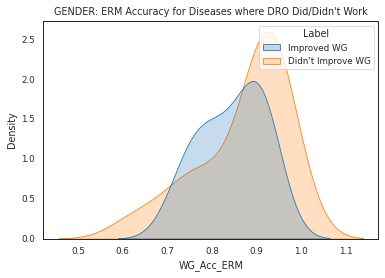

In [241]:
fig = sns.kdeplot(data=stack,x="WG_Acc_ERM", hue="Label", shade=True)
fig.set_title("GENDER: ERM Accuracy for Diseases where DRO Did/Didn't Work")
fig.figure.savefig(output_dir + "gender_improvement_plot.pdf")

## Loss

### Gathering losses

In [242]:
loss_dfs = {}
for pt in phenotypes:
    loss_dfs[pt] = get_loss_df(pf_gender_dro_path, pf_gender_nodro_path, pt)

In [345]:
final_epoch_losses = []

for pt, loss_df in loss_dfs.items():
    if "_" in pt:
        pt = pt.split("_")[-1]
    final_epoch_losses.append({
        "Disease": pt,
        "Train_DRO": loss_df[loss_df["DRO"]]["Train"].iloc[-1],
        "Train_ERM": loss_df[~(loss_df["DRO"])]["Train"].iloc[-1],
        "Val_DRO": loss_df[loss_df["DRO"]]["Val"].iloc[-1],
        "Val_ERM": loss_df[~(loss_df["DRO"])]["Val"].iloc[-1],
        "DRO_Worked?": results_table[results_table["Disease"] == pt]["WG_Acc_Improved?"].values[0]
    })
final_epoch_losses = pd.DataFrame(final_epoch_losses)
final_epoch_losses["TRAIN DRO less?"] = (final_epoch_losses["Train_DRO"] < final_epoch_losses["Train_ERM"])
final_epoch_losses["VAL DRO less?"] = (final_epoch_losses["Val_DRO"] < final_epoch_losses["Val_ERM"])

In [377]:
final_epoch_losses.head()

,Disease,Train_DRO,Train_ERM,Val_DRO,Val_ERM,DRO_Worked?,TRAIN DRO less?,VAL DRO less?
0,Acute and unspecified renal failure,0.364888,0.338186,0.447827,0.425037,True,False,False
1,Acute cerebrovascular disease,0.104367,0.104033,0.163823,0.177768,False,False,True
2,Acute myocardial infarction,0.233793,0.211659,0.259346,0.276361,False,False,True
3,Cardiac dysrhythmias,0.456946,0.466163,0.552916,0.549261,True,True,False
4,Chronic kidney disease,0.261892,0.279089,0.294799,0.281723,False,True,False


### Relationship between DRO loss (compared to ERM loss) and whether DRO works

In [375]:
x = ((final_epoch_losses["DRO_Worked?"] == final_epoch_losses["TRAIN DRO less?"]).sum()/len(final_epoch_losses)).round(2)
y = ((final_epoch_losses["DRO_Worked?"] == final_epoch_losses["VAL DRO less?"]).sum()/len(final_epoch_losses)).round(2)
print("Percentage of time that DRO training loss was less AND DRO worked:", x)
print("Percentage of time that DRO validation loss was less AND DRO worked:", y)

Percentage of time that DRO training loss was less AND DRO worked: 0.68
Percentage of time that DRO validation loss was less AND DRO worked: 0.54


In [376]:
x = (~final_epoch_losses[~final_epoch_losses["TRAIN DRO less?"]]["DRO_Worked?"]).mean().round(2)
y = (~final_epoch_losses[~final_epoch_losses["VAL DRO less?"]]["DRO_Worked?"]).mean().round(2)
print("Percentage of time that DRO training loss was greater AND DRO didn't work", x)
print("Percentage of time that DRO validation loss was greater AND DRO didn't work", y)
print("Conclusion: When DRO training loss is more, DRO is likely to not work")

Percentage of time that DRO training loss was greater AND DRO didn't work 0.73
Percentage of time that DRO validation loss was greater AND DRO didn't work 0.69
Conclusion: When DRO training loss is more, DRO is likely to not work


### Loss curves

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


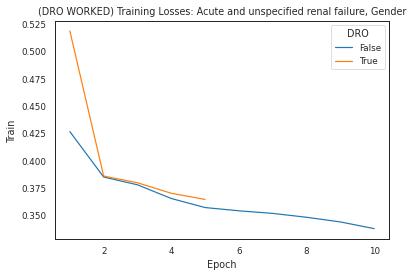

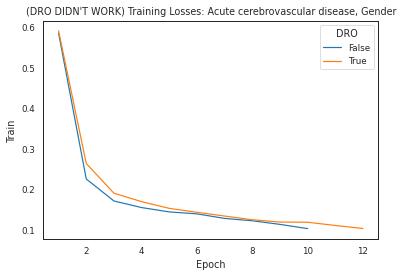

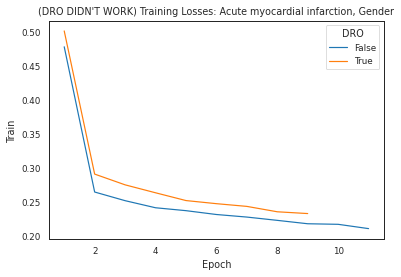

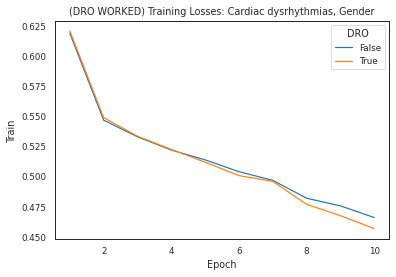

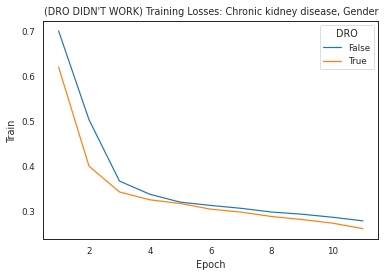

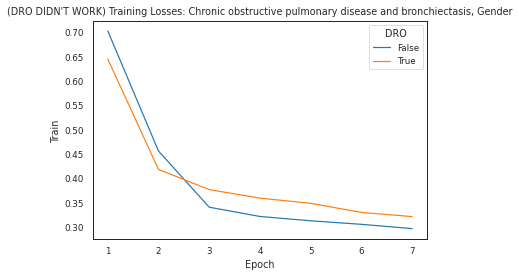

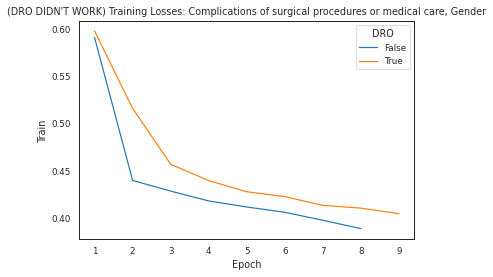

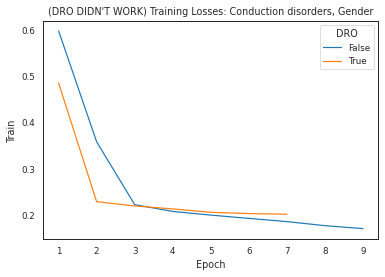

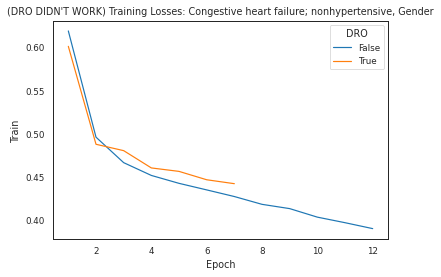

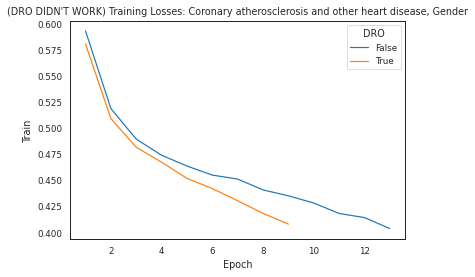

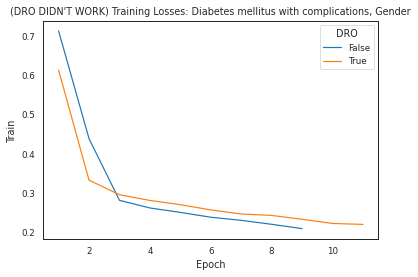

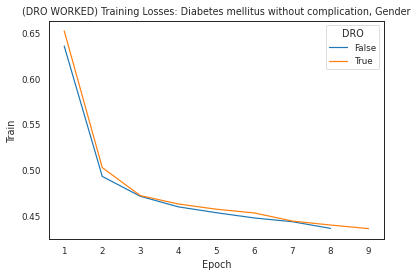

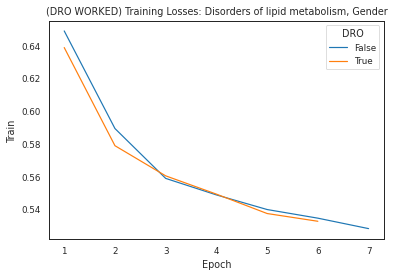

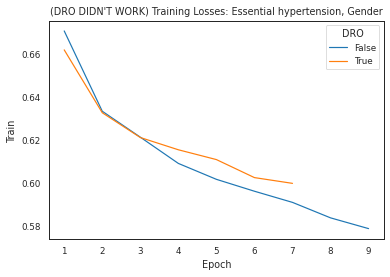

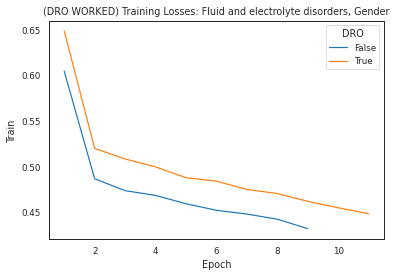

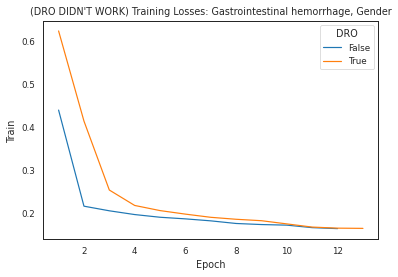

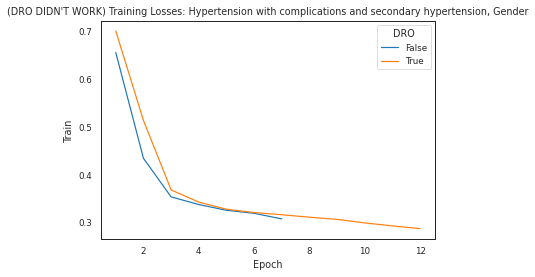

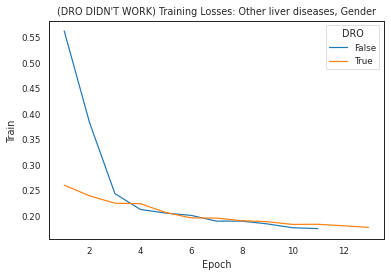

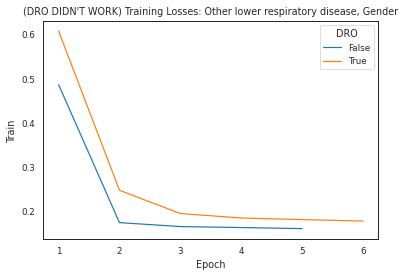

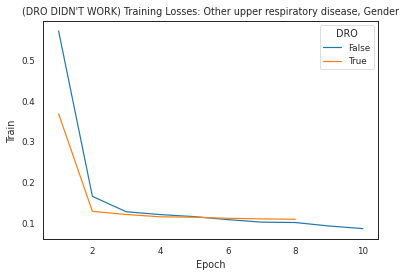

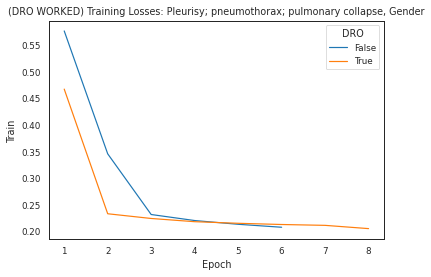

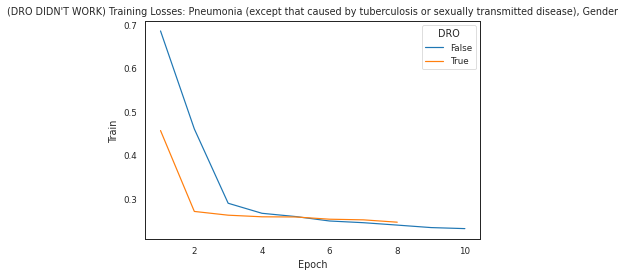

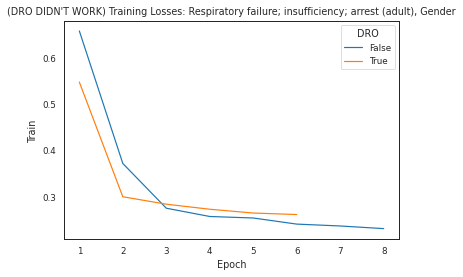

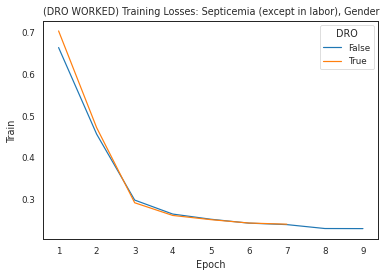

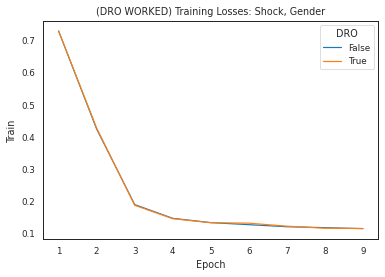

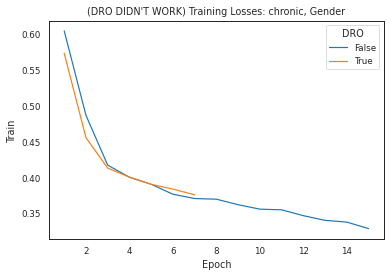

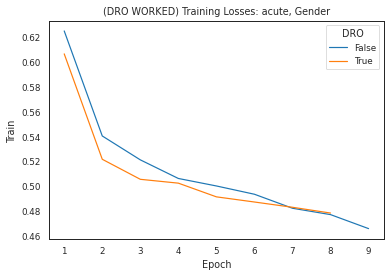

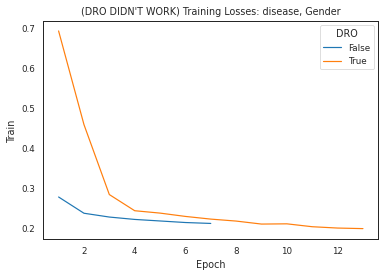

In [310]:
import matplotlib.pyplot as plt
for pt, loss_df in loss_dfs.items():
    if "_" in pt:
        pt = pt.split("_")[-1]
    dro_worked = "(DRO WORKED)" if results_table[results_table["Disease"] == pt]["WG_Acc_Improved?"].values[0] else "(DRO DIDN'T WORK)"
    
    plt.figure()
    train_loss_fig = sns.lineplot(data=loss_df[["Train", "DRO", "Epoch"]], x="Epoch", y="Train", hue="DRO")
    train_loss_fig.set_title(f"{dro_worked} Training Losses: {pt}, Gender")
    train_loss_fig.figure.savefig(output_dir + f"gender_train_loss_{pt}.pdf")
    
    plt.figure()
    val_loss_fig = sns.lineplot(data=loss_df[["Val", "DRO", "Epoch"]], x="Epoch", y="Val", hue="DRO")
    val_loss_fig.set_title(f"{dro_worked} Validation Losses: {pt}, Gender")
    val_loss_fig.figure.savefig(output_dir + f"gender_val_loss_{pt}.pdf")

# RACE RESULTS

## Build results table

In [388]:
race_results = get_race_results(option="all")
results_table = []
for disease, dres in race_results.items():
    metrics = {}
    metrics["Acc_DRO"] = mean(list(dres["DRO"].values()))
    metrics["Acc_ERM"] = mean(list(dres["ERM"].values()))
    metrics["WG_Acc_DRO"] = min(list(dres["DRO"].values()))
    metrics["WG_Acc_ERM"] = min(list(dres["ERM"].values()))
    metrics["WG_Acc_Improved?"] = metrics["WG_Acc_DRO"] > metrics["WG_Acc_ERM"]
    metrics["WG_DRO"] = [races[k] for k, v in dres["DRO"].items() if v == min(list(dres["DRO"].values()))][0]
    metrics["WG_ERM"] = [races[k] for k, v in dres["ERM"].items() if v == min(list(dres["ERM"].values()))][0]
    metrics["Disease"] = disease

    results_table.append(metrics)
results_table = pd.DataFrame(results_table)

summary = pd.DataFrame({"Acc_decrease": results_table["Acc_ERM"] - results_table["Acc_DRO"].mean(), 
                       "WG_Acc_improvement": results_table["WG_Acc_DRO"] - results_table["WG_Acc_ERM"],
                       "WG_Changed?": results_table["WG_DRO"] != results_table["WG_ERM"]})

In [389]:
results_table.head()

,Acc_DRO,Acc_ERM,WG_Acc_DRO,WG_Acc_ERM,WG_Acc_Improved?,WG_DRO,WG_ERM,Disease
0,0.768054,0.763478,0.710098,0.680782,True,Unknown,Unknown,Cardiac dysrhythmias
1,0.768536,0.770286,0.691489,0.680851,True,Hispanic,Hispanic,Diabetes mellitus without complication
2,0.933824,0.937600,0.898305,0.898305,False,Other,Other,Other liver diseases
3,0.840231,0.845172,0.762215,0.768730,False,Unknown,Unknown,Complications of surgical procedures or medica...
4,0.617241,0.636917,0.578723,0.613333,False,Black,Asian,Essential hypertension


In [390]:
results_table.to_csv(output_dir + "race_PF_summary.csv", index=False)

## Summary stats

In [391]:
print("Avg avg accuracy decrease: ", (results_table["Acc_ERM"] - results_table["Acc_DRO"]).mean())
print("Percent of Diseases with Avg acc increase: ", (results_table["Acc_ERM"] < results_table["Acc_DRO"]).mean())
print("Percent of Diseases with Avg acc decrease: ", (results_table["Acc_ERM"] > results_table["Acc_DRO"]).mean())
print("Percent of Diseases with WG Acc increase: ", (results_table["WG_Acc_DRO"] > results_table["WG_Acc_ERM"]).mean())
print("Avg ERM WG Acc when DRO works:", (results_table["WG_Acc_ERM"][results_table["WG_Acc_Improved?"] == True]).mean())
print("Avg ERM WG Acc when DRO doesn't work:", (results_table["WG_Acc_ERM"][results_table["WG_Acc_Improved?"] == False]).mean()) 

Avg avg accuracy decrease:  0.0002788823819665974
Percent of Diseases with Avg acc increase:  0.5
Percent of Diseases with Avg acc decrease:  0.4642857142857143
Percent of Diseases with WG Acc increase:  0.32142857142857145
Avg ERM WG Acc when DRO works: 0.7596928736971564
Avg ERM WG Acc when DRO doesn't work: 0.8390576895447717


## WG improvement by race

In [409]:
per_race_improvement = {}
for idx, race in races.items():
    per_race_improvement[race] = {
        "% DRO improvement": (results_table[results_table["WG_ERM"] == race]["WG_Acc_Improved?"]).mean(),
        "Avg WG ERM acc": (results_table[results_table["WG_ERM"] == race]["WG_Acc_ERM"]).mean(),
        "Size": len(results_table[results_table["WG_ERM"] == race]["WG_Acc_ERM"]),
        "Diseases": results_table[results_table["WG_ERM"] == race]["Disease"].values
    }
    
per_race_improvement = pd.DataFrame(per_race_improvement).transpose().sort_values(by="% DRO improvement")
per_race_improvement.to_csv(output_dir + "per_race_wg_improvement.csv", index=False)

In [410]:
per_race_improvement

,% DRO improvement,Avg WG ERM acc,Size,Diseases
White,0,0.914979,3,[Chronic obstructive pulmonary disease and bro...
Asian,0,0.84,6,"[Essential hypertension, Other lower respirato..."
Black,0.375,0.817021,8,"[Septicemia (except in labor), Congestive hear..."
Unknown,0.4,0.723127,5,"[Cardiac dysrhythmias, Complications of surgic..."
Hispanic,0.666667,0.783688,3,"[Diabetes mellitus without complication, acute..."
Other,0.666667,0.830508,3,"[Other liver diseases, Fluid and electrolyte d..."


## Relationship between WG Accuracy and whether DRO works

In [200]:
dro_worked = results_table[results_table["WG_Acc_Improved?"] == True]
dro_worked["Label"] = "Improved WG"
dro_didnt_work = results_table[results_table["WG_Acc_Improved?"] == False]
dro_didnt_work["Label"] = "Didn't Improve WG"
stack = pd.concat([dro_worked[["WG_Acc_ERM", "Label"]], dro_didnt_work[["WG_Acc_ERM", "Label"]]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


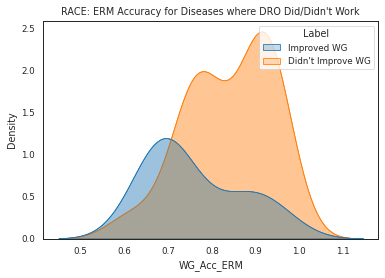

In [201]:
sns.kdeplot(data=stack,x="WG_Acc_ERM", hue="Label", shade=True).set_title("RACE: ERM Accuracy for Diseases where DRO Did/Didn't Work")
fig = sns.kdeplot(data=stack,x="WG_Acc_ERM", hue="Label", shade=True)
fig.set_title("RACE: ERM Accuracy for Diseases where DRO Did/Didn't Work")
fig.figure.savefig(output_dir + "race_improvement_plot.pdf")

## Loss

### Gathering losses

In [380]:
loss_dfs = {}
for pt in phenotypes:
    loss_dfs[pt] = get_loss_df(pf_race_dro_path, pf_race_nodro_path, pt)

In [381]:
final_epoch_losses = []

for pt, loss_df in loss_dfs.items():
    if "_" in pt:
        pt = pt.split("_")[-1]
    final_epoch_losses.append({
        "Disease": pt,
        "Train_DRO": loss_df[loss_df["DRO"]]["Train"].iloc[-1],
        "Train_ERM": loss_df[~(loss_df["DRO"])]["Train"].iloc[-1],
        "Val_DRO": loss_df[loss_df["DRO"]]["Val"].iloc[-1],
        "Val_ERM": loss_df[~(loss_df["DRO"])]["Val"].iloc[-1],
        "DRO_Worked?": results_table[results_table["Disease"] == pt]["WG_Acc_Improved?"].values[0]
    })
final_epoch_losses = pd.DataFrame(final_epoch_losses)
final_epoch_losses["TRAIN DRO less?"] = (final_epoch_losses["Train_DRO"] < final_epoch_losses["Train_ERM"])
final_epoch_losses["VAL DRO less?"] = (final_epoch_losses["Val_DRO"] < final_epoch_losses["Val_ERM"])

In [382]:
final_epoch_losses.head()

,Disease,Train_DRO,Train_ERM,Val_DRO,Val_ERM,DRO_Worked?,TRAIN DRO less?,VAL DRO less?
0,Acute and unspecified renal failure,0.349459,0.338186,0.284240,0.425037,True,False,True
1,Acute cerebrovascular disease,0.115821,0.104033,0.102833,0.177768,False,False,True
2,Acute myocardial infarction,0.232015,0.211659,0.199320,0.276361,False,False,True
3,Cardiac dysrhythmias,0.527563,0.466163,0.366427,0.549261,True,False,True
4,Chronic kidney disease,0.273328,0.292508,0.189278,0.289070,False,True,True


### Relationship between DRO loss (compared to ERM loss) and whether DRO works

In [384]:
x = ((final_epoch_losses["DRO_Worked?"] == final_epoch_losses["TRAIN DRO less?"]).sum()/len(final_epoch_losses)).round(2)
y = ((final_epoch_losses["DRO_Worked?"] == final_epoch_losses["VAL DRO less?"]).sum()/len(final_epoch_losses)).round(2)
print("Percentage of time that DRO training loss was less AND DRO worked:", x)
print("Percentage of time that DRO validation loss was less AND DRO worked:", y)

Percentage of time that DRO training loss was less AND DRO worked: 0.64
Percentage of time that DRO validation loss was less AND DRO worked: 0.32


In [386]:
x = (~final_epoch_losses[~final_epoch_losses["TRAIN DRO less?"]]["DRO_Worked?"]).mean()
y = (~final_epoch_losses[~final_epoch_losses["VAL DRO less?"]]["DRO_Worked?"]).mean()
print("Percentage of time that DRO training loss was greater AND DRO didn't work", x)
print("Percentage of time that DRO validation loss was greater AND DRO didn't work", y)
print("Conclusion: When DRO training loss is more, DRO is likely to not work")

Percentage of time that DRO training loss was greater AND DRO didn't work 0.7647058823529411
Percentage of time that DRO validation loss was greater AND DRO didn't work nan
Conclusion: When DRO training loss is more, DRO is likely to not work


### Loss curves

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


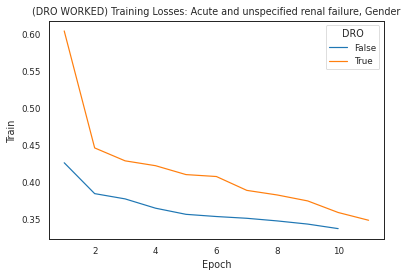

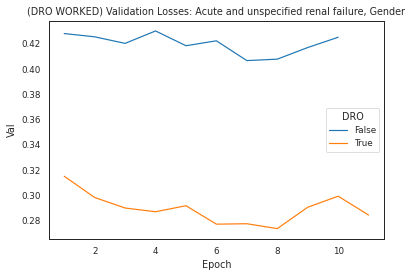

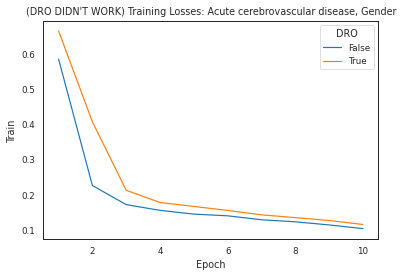

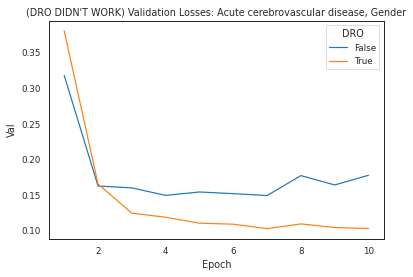

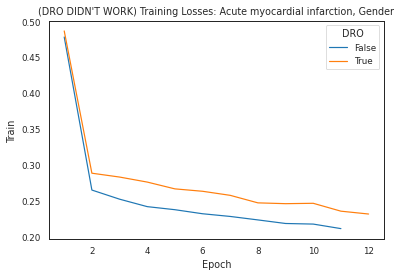

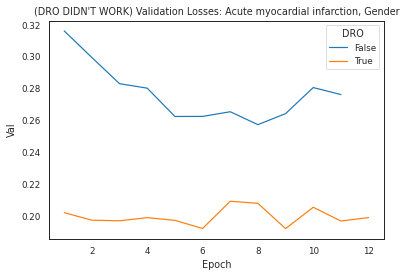

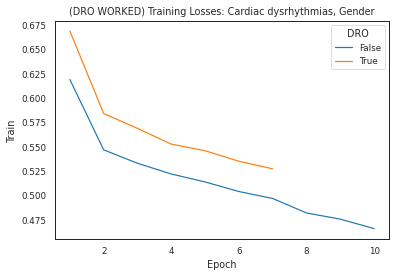

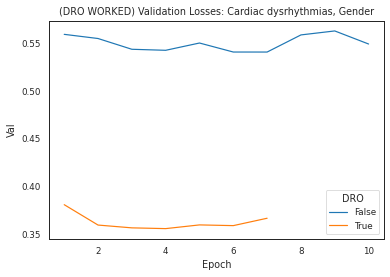

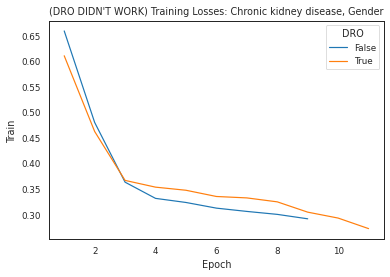

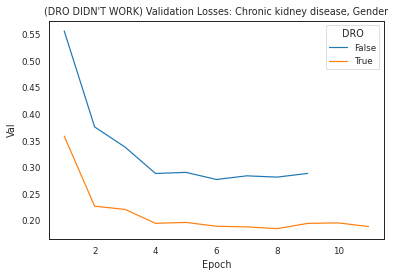

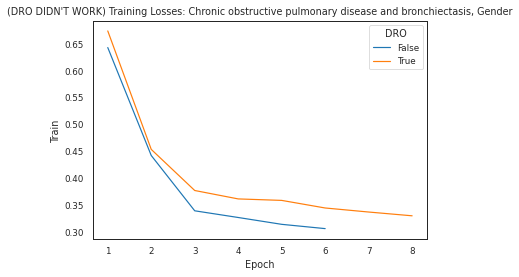

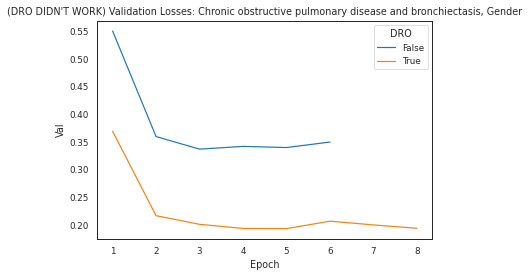

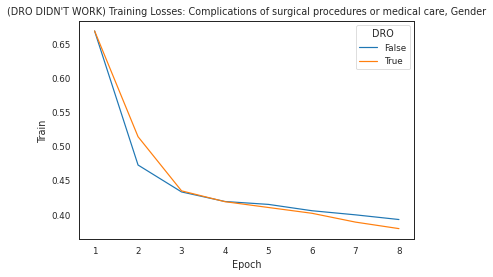

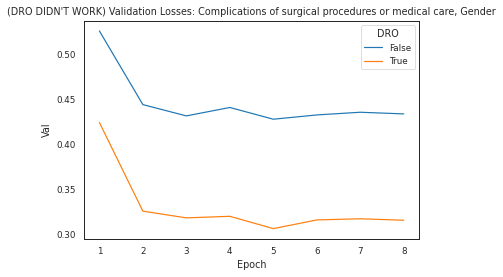

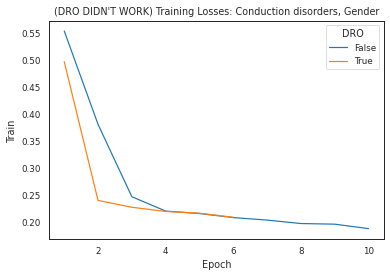

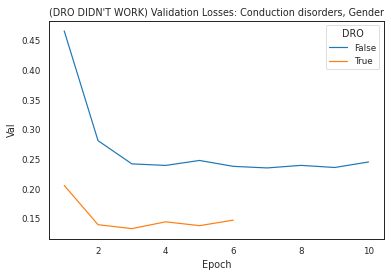

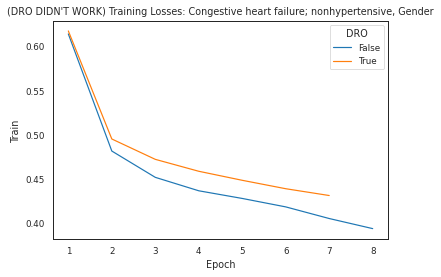

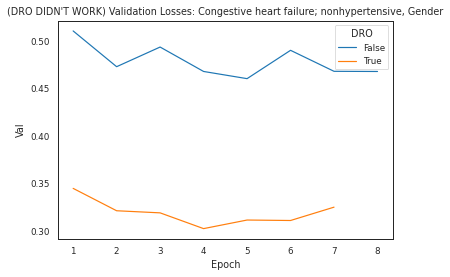

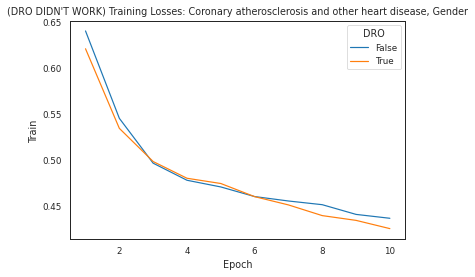

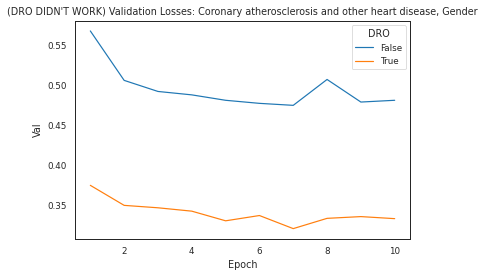

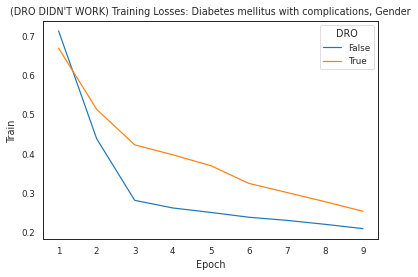

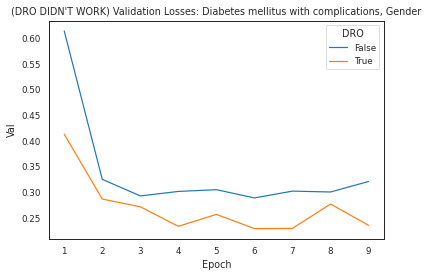

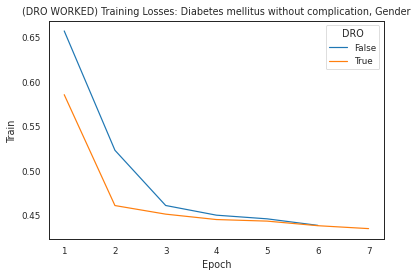

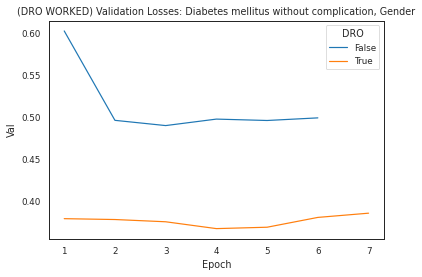

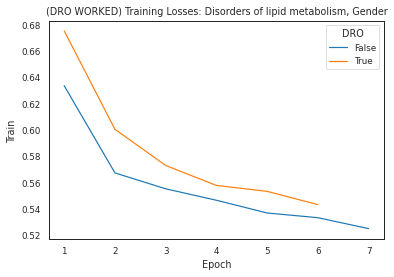

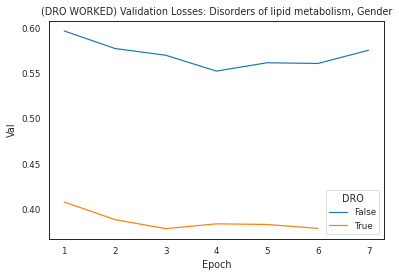

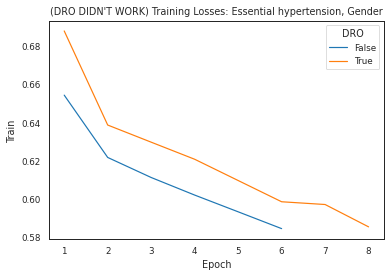

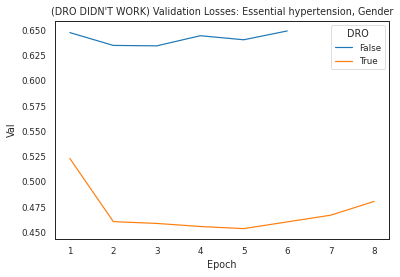

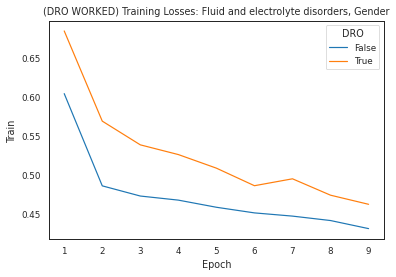

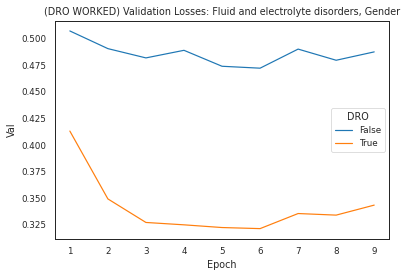

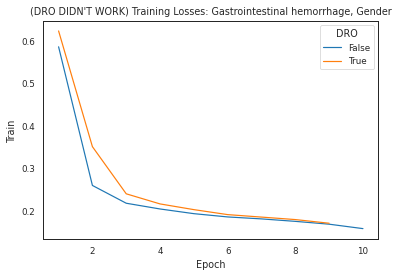

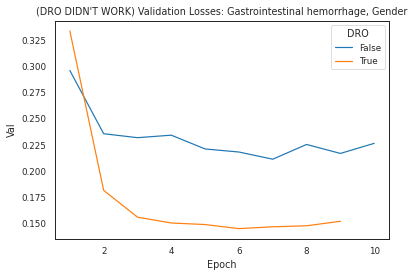

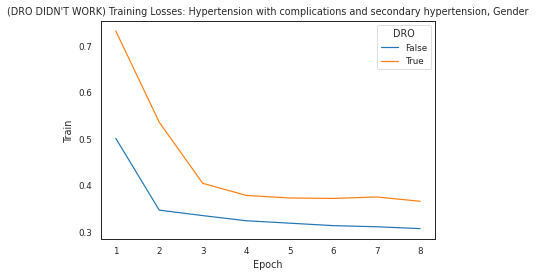

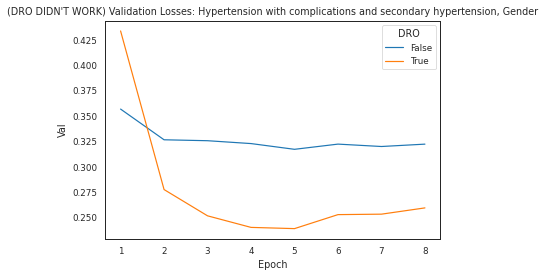

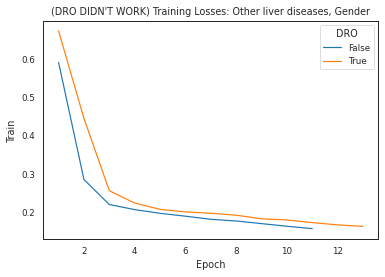

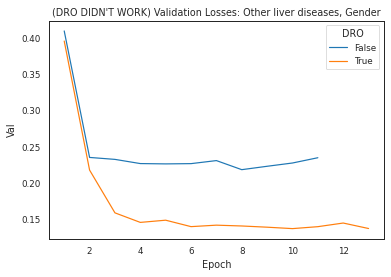

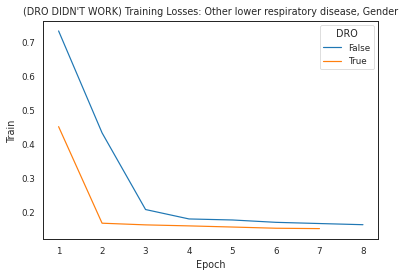

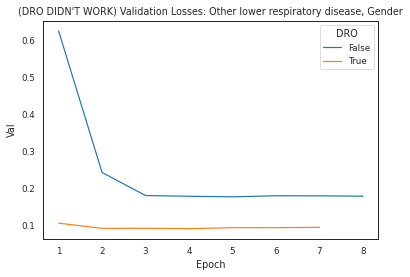

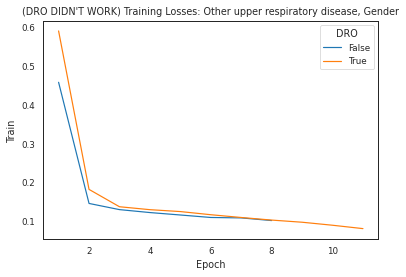

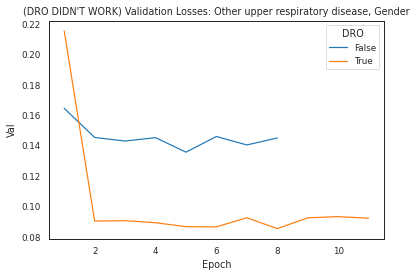

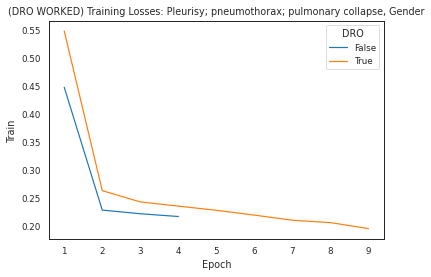

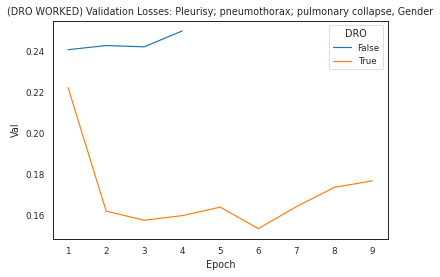

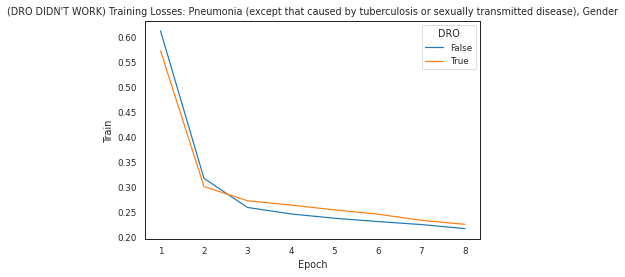

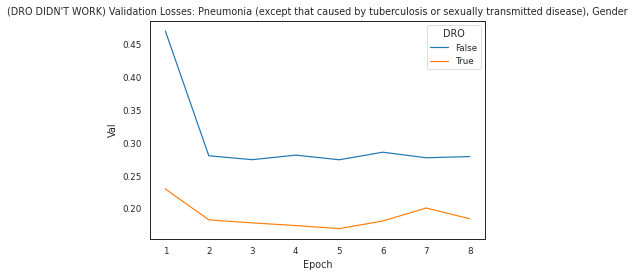

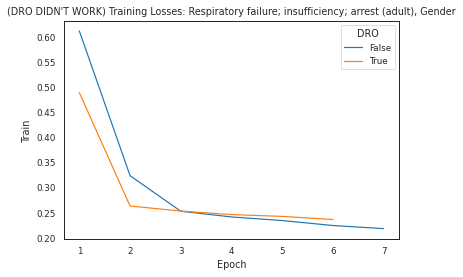

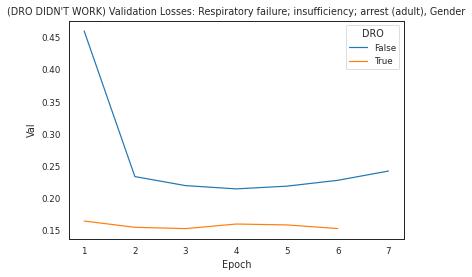

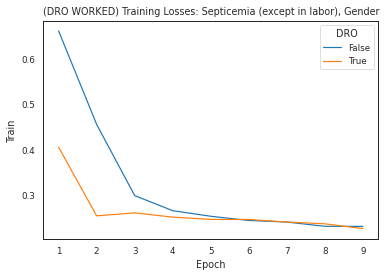

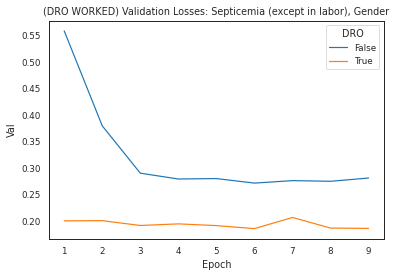

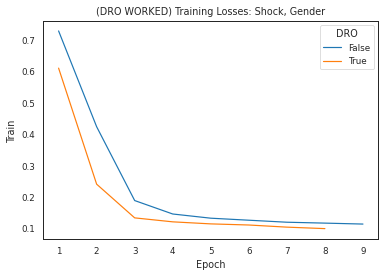

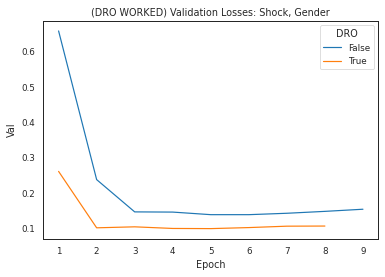

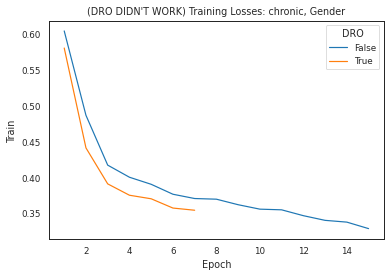

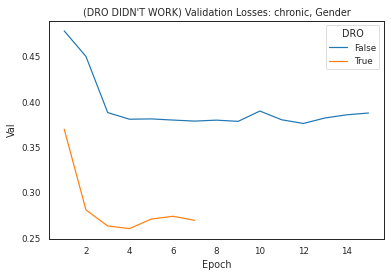

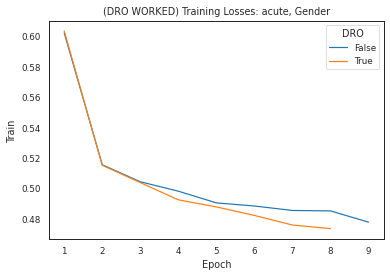

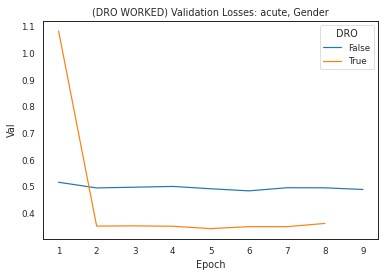

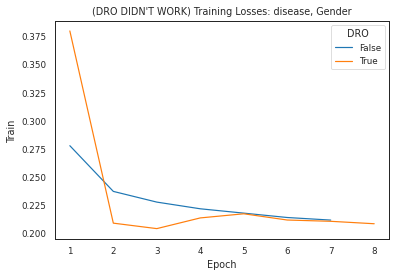

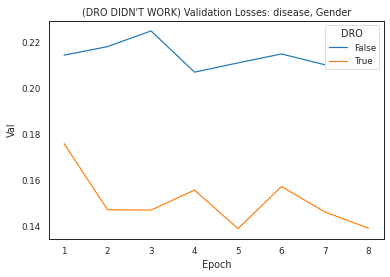

In [383]:
import matplotlib.pyplot as plt
for pt, loss_df in loss_dfs.items():
    if "_" in pt:
        pt = pt.split("_")[-1]
    dro_worked = "(DRO WORKED)" if results_table[results_table["Disease"] == pt]["WG_Acc_Improved?"].values[0] else "(DRO DIDN'T WORK)"
    
    plt.figure()
    train_loss_fig = sns.lineplot(data=loss_df[["Train", "DRO", "Epoch"]], x="Epoch", y="Train", hue="DRO")
    train_loss_fig.set_title(f"{dro_worked} Training Losses: {pt}, Gender")
    train_loss_fig.figure.savefig(output_dir + f"gender_train_loss_{pt}.pdf")
    
    plt.figure()
    val_loss_fig = sns.lineplot(data=loss_df[["Val", "DRO", "Epoch"]], x="Epoch", y="Val", hue="DRO")
    val_loss_fig.set_title(f"{dro_worked} Validation Losses: {pt}, Gender")
    val_loss_fig.figure.savefig(output_dir + f"gender_val_loss_{pt}.pdf")

# Extra shit

In [33]:
race_results = get_race_results(option="worst_group", as_df=True)
get_basic_metrics(race_results)

{'percent_improved': 0.39285714285714285,
 'mean_bias': 0.10735596399733835,
 'std_bias': 0.06274630281373961}

In [36]:
print(mean(race_results["NO DRO"][race_results["Improved?"] == True]))
print(mean(race_results["NO DRO"][race_results["Improved?"] == False]))

0.13171924532992277
0.09159148784096015


In [75]:
full_race_results = []
for opt in ["white_v_nonwhite", "white_v_black", "white_v_asian", "white_v_hispanic"]:
    race_results = get_race_results(option=opt, as_df=True)
    metrics = get_basic_metrics(race_results)
    metrics["Race"] = opt.split("_")[-1].capitalize()
    full_race_results.append(metrics)
full_race_results = pd.DataFrame(full_race_results)
full_race_results

,percent_improved,mean_bias,std_bias,Race
0,0.464286,0.023954,0.018188,Nonwhite
1,0.321429,0.034817,0.038878,Black
2,0.357143,0.030930,0.030735,Asian
3,0.392857,0.035584,0.026233,Hispanic


In [76]:
percent_improved = len(race_results[race_results["Improved?"] == True])/len(race_results)
mean_bias = race_results["NO DRO"].abs().mean()
std_bias = race_results["NO DRO"].abs().std()

In [77]:
print("percent improved ", percent_improved)
print("mean bias (in either direction) ", mean_bias)
print("std bias ", std_bias)

percent improved  0.39285714285714285
mean bias (in either direction)  0.035583853352991
std bias  0.026232908644962766


In [78]:
race_results = get_race_results(option="white_v_black", as_df=True)

In [13]:
get_basic_metrics(race_results)

{'percent_improved': 0.32142857142857145,
 'mean_bias': 0.8135475701651812,
 'std_bias': 0.10519679683262602}

In [14]:
percent_improved = len(race_results[race_results["Improved?"] == True])/len(race_results)
mean_bias = race_results["NO DRO"].abs().mean()
std_bias = race_results["NO DRO"].abs().std()
print("percent improved ", percent_improved)
print("mean bias (in either direction) ", mean_bias)
print("std bias ", std_bias)

percent improved  0.32142857142857145
mean bias (in either direction)  0.8135475701651812
std bias  0.10519679683262602


In [25]:
race_results = get_race_results(option="worst_group", as_df=True)

In [26]:
percent_improved = len(race_results[race_results["Improved?"] == True])/len(race_results)
mean_bias = race_results["NO DRO"].abs().mean()
std_bias = race_results["NO DRO"].abs().std()
print("percent improved ", percent_improved)
print("mean bias (in either direction) ", mean_bias)
print("std bias ", std_bias)

percent improved  0.32142857142857145
mean bias (in either direction)  0.8135475701651812
std bias  0.10519679683262602


In [15]:
race_results = get_race_results(option="all", as_df=True)

In [16]:
race_results

{'Cardiac dysrhythmias': {'DRO': {0: 0.7348119575699132,
   1: 0.7617021276595745,
   2: 0.7733333333333333,
   3: 0.7978723404255319,
   4: 0.8305084745762712,
   5: 0.7100977198697068},
  'NO DRO': {0: 0.7198649951783992,
   1: 0.7489361702127659,
   2: 0.7733333333333333,
   3: 0.776595744680851,
   4: 0.8813559322033898,
   5: 0.6807817589576547}},
 'Diabetes mellitus without complication': {'DRO': {0: 0.8076181292189006,
   1: 0.7872340425531915,
   2: 0.8266666666666667,
   3: 0.6914893617021277,
   4: 0.7457627118644068,
   5: 0.752442996742671},
  'NO DRO': {0: 0.8114754098360656,
   1: 0.7914893617021277,
   2: 0.8266666666666667,
   3: 0.6808510638297872,
   4: 0.7457627118644068,
   5: 0.7654723127035831}},
 'Other liver diseases': {'DRO': {0: 0.9363548698167792,
   1: 0.9106382978723404,
   2: 0.9466666666666667,
   3: 0.9468085106382979,
   4: 0.8983050847457628,
   5: 0.9641693811074918},
  'NO DRO': {0: 0.9397299903567985,
   1: 0.9234042553191489,
   2: 0.94666666666666

# Renaming files

In [206]:
import pickle

base_path = "/om/user/shobhita/data/6.864/"
output_path = "/om/user/shobhita/src/HurtfulWords/shobhita_pred_results/"
pf_race_nodro_path = base_path + "task_phenotype_first_outputs_dro_False_group_ethnicity_to_use_freezebert_True/"
pf_race_dro_path = base_path + "task_phenotype_first_outputs_dro_True_group_ethnicity_to_use_freezebert_True/"
pf_gender_nodro_path = base_path + "task_phenotype_first_outputs_dro_False_group_gender_freezebert_True/"
pf_gender_dro_path = base_path + "task_phenotype_first_outputs_dro_True_group_gender_freezebert_True/"

for path, name in zip([pf_race_nodro_path, pf_race_dro_path, pf_gender_nodro_path, pf_gender_dro_path], ["race_false", "race_true", "gender_false", "gender_true"]):
    for col in os.listdir(path):
        full_path = path + col + "/preds.pkl"
        disease = col.split("_")[-1]
        new_path = output_path + f"{name}_{disease}.pkl"
        result = pd.read_pickle(full_path)
        with open(new_path, "wb") as handle:
            pickle.dump(result, handle)
        print(f"Done with {name}, {col}")

Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Cardiac dysrhythmias
Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Diabetes mellitus without complication
Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Other liver diseases
Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Complications of surgical procedures or medical care
Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Essential hypertension
Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_any_acute
Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Chronic obstructive pulmonary disease and bronchiectasis
Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Other lower respiratory disease
Done with race_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Disorders of lipid metabolism
Done with race_false, phenotype_first_baseline_clinical_B

Done with gender_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_any_chronic
Done with gender_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Diabetes mellitus with complications
Done with gender_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Shock
Done with gender_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Respiratory failure; insufficiency; arrest (adult)
Done with gender_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Hypertension with complications and secondary hypertension
Done with gender_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Fluid and electrolyte disorders
Done with gender_false, phenotype_first_baseline_clinical_BERT_1_epoch_512_Pleurisy; pneumothorax; pulmonary collapse
Done with gender_true, phenotype_first_baseline_clinical_BERT_1_epoch_512_Cardiac dysrhythmias
Done with gender_true, phenotype_first_baseline_clinical_BERT_1_epoch_512_Diabetes mellitus without complication
Done with gender_true, phen

In [53]:
new_path

'/om/user/shobhita/data/6.864/metric_results/race_false_Cardiac dysrhythmias.pkl'